In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps


import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')

dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

from matplotlib.ticker import MaxNLocator


import jlinops
import sampi

# Toy problem

In [2]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.1
noise_var = noise_stdev**2
F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=10, mode="constant")
noisy_signal = F.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

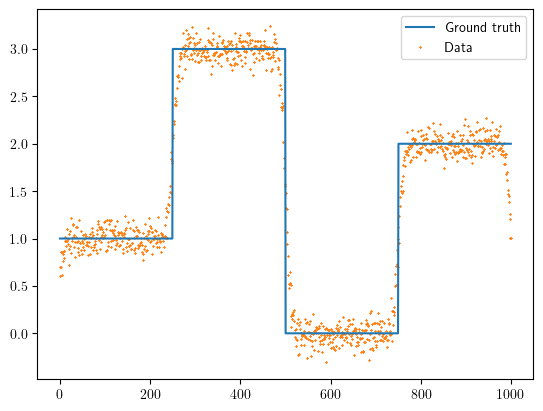

In [3]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [55]:
# Define forward operator and regularization matrix
# F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=5, mode="constant")
BOUNDARY = "zero"
Rmat, Wmat = jlinops.first_order_derivative_1d(n, boundary=BOUNDARY)
#W = jlinops.MatrixLinearOperator(Wmat)
W = None
R = jlinops.MatrixLinearOperator(Rmat)

In [56]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))



# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [57]:
# Prior parameters
#reg_lambda = 2.0*1e2
reg_lambda = 2.0*1e2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}

# Create solver
solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=None, pdata=pdata)

In [58]:
from scipy.sparse.linalg import cg as sp_cg

In [59]:
# Initialize everything at the least-squares reconstruction?
x0, _ = sp_cg( (F.T @ F) + 1.0*(R.T @ R), F.T @ noisy_signal, tol=1e-4 )

In [60]:
data_smart = solver.solve(max_iters=100, priorconditioning=False, x0=x0, early_stopping=True, warmstarting=True, eps=1e-3)

In [61]:
data = solver.solve(max_iters=100, priorconditioning=False, x0=None, early_stopping=True, warmstarting=True, eps=1e-3)

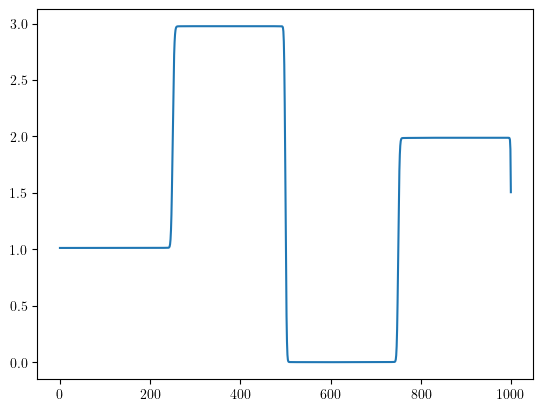

In [62]:
plt.plot(data_smart["x"])
plt.show()

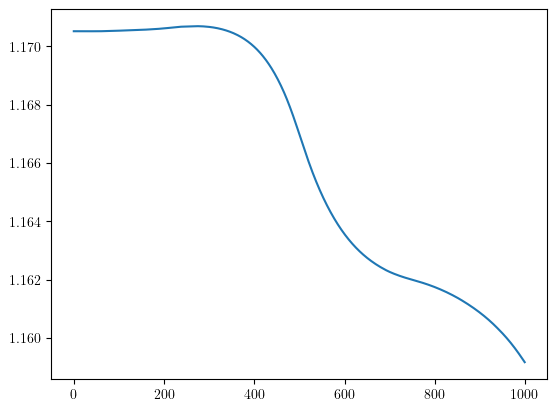

In [63]:
plt.plot(data["x"])
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


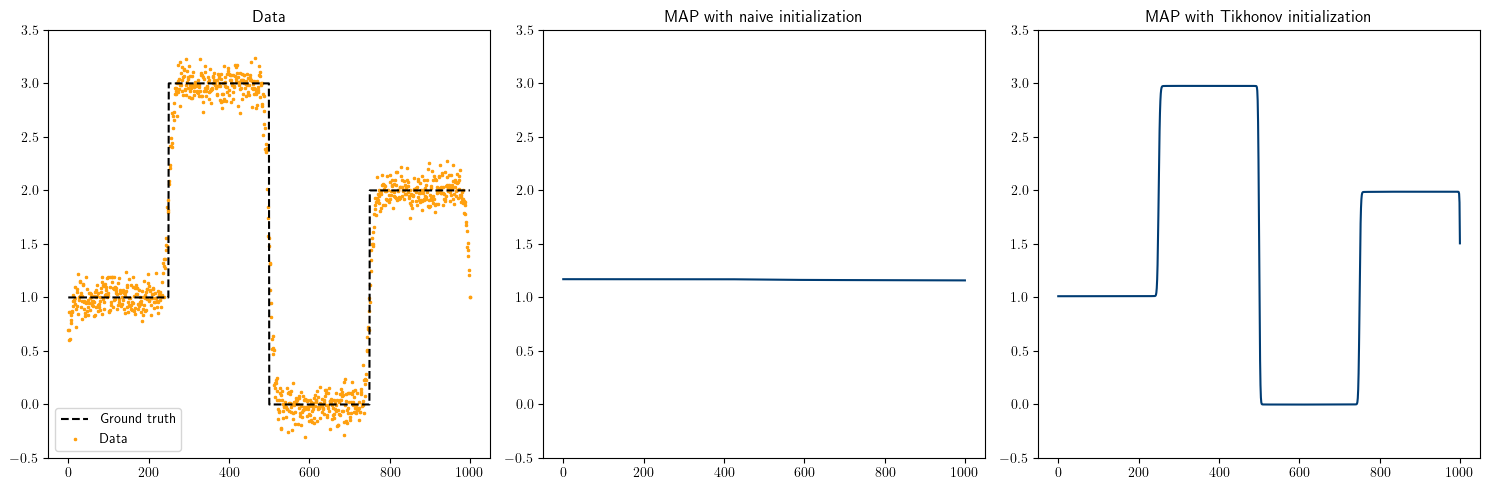

In [76]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

#axs[0].scatter(grid, noisy_signal)
axs[0].plot(grid, ground_truth, label="Ground truth", color="black", ls="--")
axs[0].scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_orange"], alpha=1.0, s=3.0)
axs[0].set_title("Data")
axs[0].set_ylim(-0.5, 3.5)
axs[0].legend(loc="lower left")

axs[1].plot(data["x"], color=dcolors["river_navy"])
axs[1].set_title("MAP with naive initialization")
axs[1].set_ylim(-0.5, 3.5)

axs[2].plot(data_smart["x"], color=dcolors["river_navy"])
axs[2].set_title("MAP with Tikhonov initialization")
axs[2].set_ylim(-0.5, 3.5)

fig.tight_layout()

fig.savefig("initialization_example.png", dpi=250, bbox_inches="tight")
fig.savefig("initialization_example.eps", bbox_inches="tight")



plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(grid, ker_contrib, color=dcolors["river_navy"])
axs[0].set_ylim(-2, 3.5)
axs[0].set_title("$\\bm{W} (\\bm{F} \\bm{W} )^\\dagger \\bm{y} \\in \\ker(\\bm{R})$")

axs[1].plot(grid, perp_contrib, color=dcolors["river_navy"])
axs[1].set_ylim(-2, 3.5)
axs[1].set_title("$\\bm{R}_{\\boldsymbol{\\theta}}^{\\#} \\bm{w}^\\star \\in \\ker(\\bm{R})^{\\perp_{\\bm{F}}} $")

axs[2].plot(grid, data["x"], color=dcolors["river_navy"], label="MAP")
axs[2].scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_orange"], alpha=1.0, s=3.0)
axs[2].legend(loc="lower right")
axs[2].set_ylim(-2, 3.5)
axs[2].set_title("$\\bm{x}^{\\star}$")

plt.tight_layout()

fig.savefig("decomposition_example.png", dpi=250, bbox_inches="tight")
fig.savefig("decomposition_example.eps", bbox_inches="tight")


plt.show()

In [234]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'noise_var', 'noise_vars', 'n_iters', 'n_Rpinv_matvec_cg_its_per_iteration', 'n_Rpinv_rmatvec_cg_its_per_iteration', 'obj_vals_each_update'])

In [235]:
print(np.sum(data["n_cg_its_per_iteration"]))

121


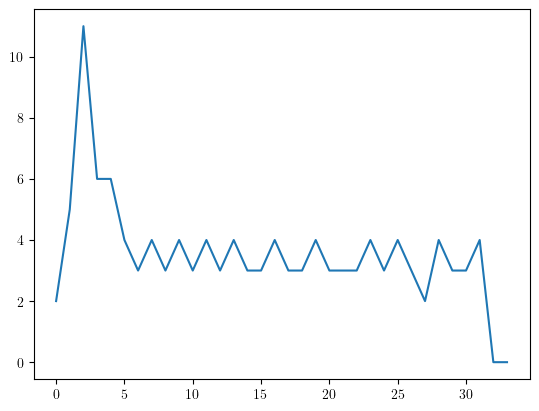

In [236]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

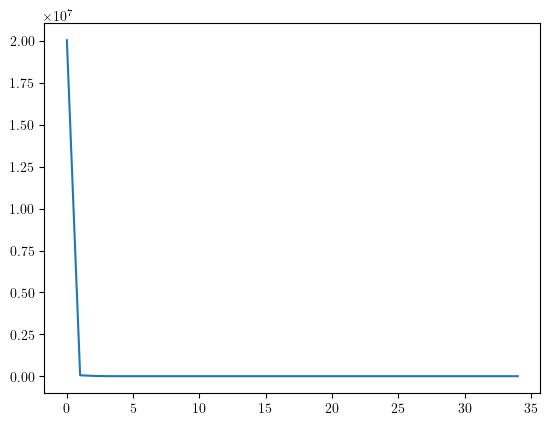

In [237]:
plt.plot(data["obj_vals"])
plt.show()

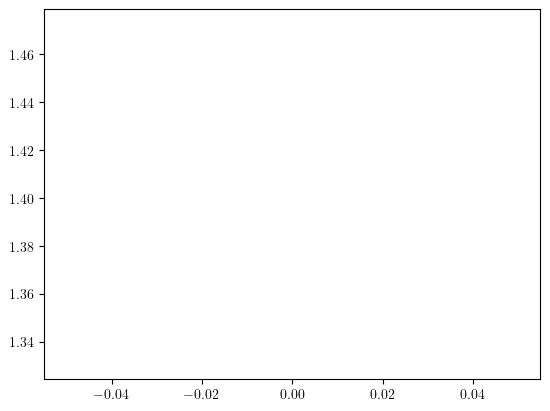

In [10]:
plt.plot(data["noise_vars"])
plt.show()

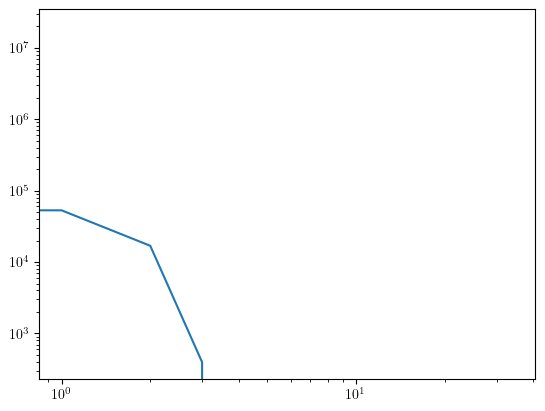

In [239]:
plt.loglog(data["obj_vals"] - 1.5*np.amin(data["obj_vals"]))
plt.show()

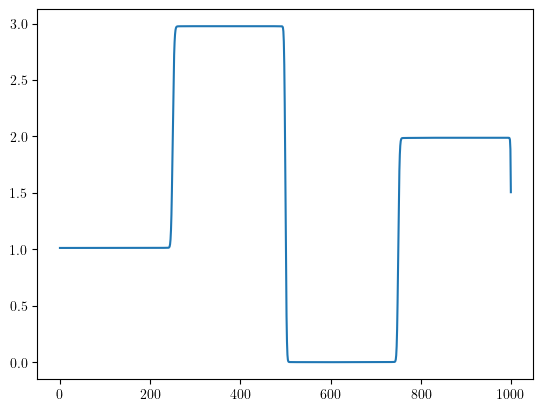

In [16]:
plt.plot(data["x"])
plt.show()

In [18]:
data["noise_var"]

0.00989108212245343

In [19]:
noise_var

0.010000000000000002

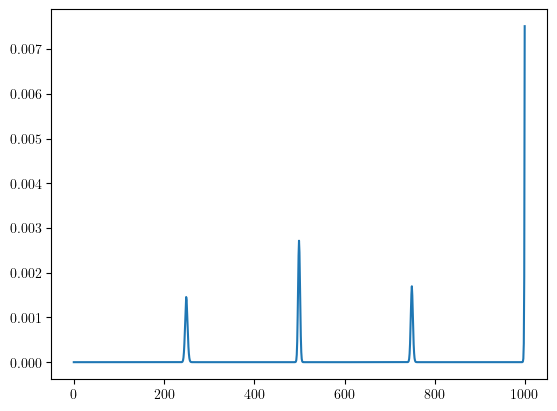

In [17]:
plt.plot(data["theta"])
plt.show()

In [251]:
ker_contrib = solver.pdata["W"] @ ( solver.pdata["FWpinv"] @ solver.y)
perp_contrib = data["x"] - ker_contrib

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


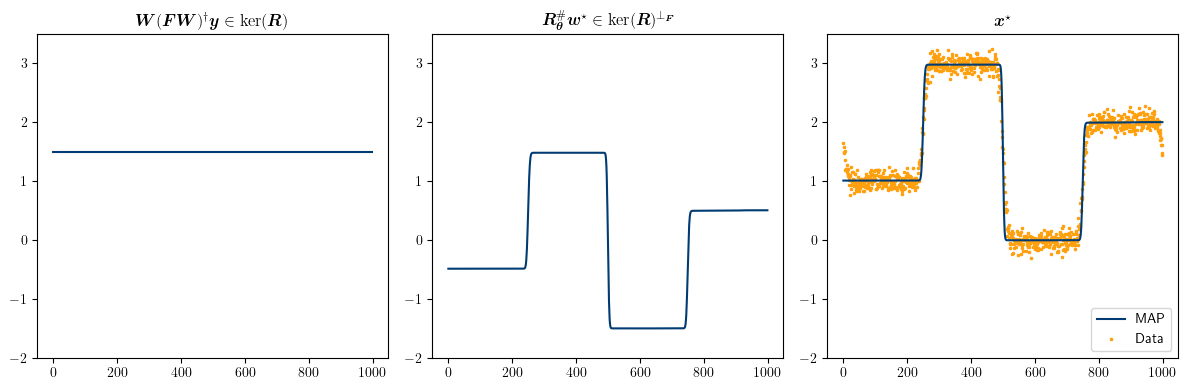

In [254]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(grid, ker_contrib, color=dcolors["river_navy"])
axs[0].set_ylim(-2, 3.5)
axs[0].set_title("$\\bm{W} (\\bm{F} \\bm{W} )^\\dagger \\bm{y} \\in \\ker(\\bm{R})$")

axs[1].plot(grid, perp_contrib, color=dcolors["river_navy"])
axs[1].set_ylim(-2, 3.5)
axs[1].set_title("$\\bm{R}_{\\boldsymbol{\\theta}}^{\\#} \\bm{w}^\\star \\in \\ker(\\bm{R})^{\\perp_{\\bm{F}}} $")

axs[2].plot(grid, data["x"], color=dcolors["river_navy"], label="MAP")
axs[2].scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_orange"], alpha=1.0, s=3.0)
axs[2].legend(loc="lower right")
axs[2].set_ylim(-2, 3.5)
axs[2].set_title("$\\bm{x}^{\\star}$")

plt.tight_layout()

fig.savefig("decomposition_example.png", dpi=250, bbox_inches="tight")
fig.savefig("decomposition_example.eps", bbox_inches="tight")


plt.show()

### Also solve with FISTA

In [102]:
# Data likelihood term
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)

# Regularization term
g = sampi.TV1DPenalty(F.shape[1], reg_lam=1e2, boundary=BOUNDARY)

obj = sampi.CompositeModelObjectiveFunction(f, g)

# Solver
solver = sampi.MFISTASolver(obj)

# Solve problem
mfista_solver_data = solver.solve(iterations=1000, L=1e0)

In [103]:
mfista_solver_data.keys()

dict_keys(['result', 'obj_vals'])

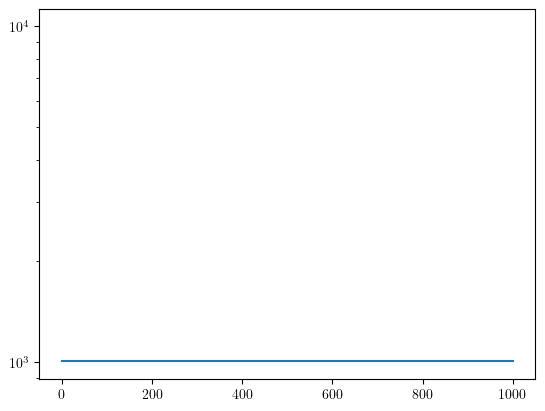

In [104]:
plt.semilogy(mfista_solver_data["obj_vals"])
plt.show()

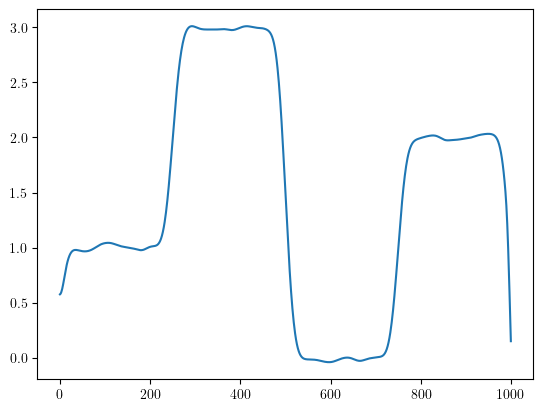

In [106]:
plt.plot(mfista_solver_data["result"])
plt.show()

# Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


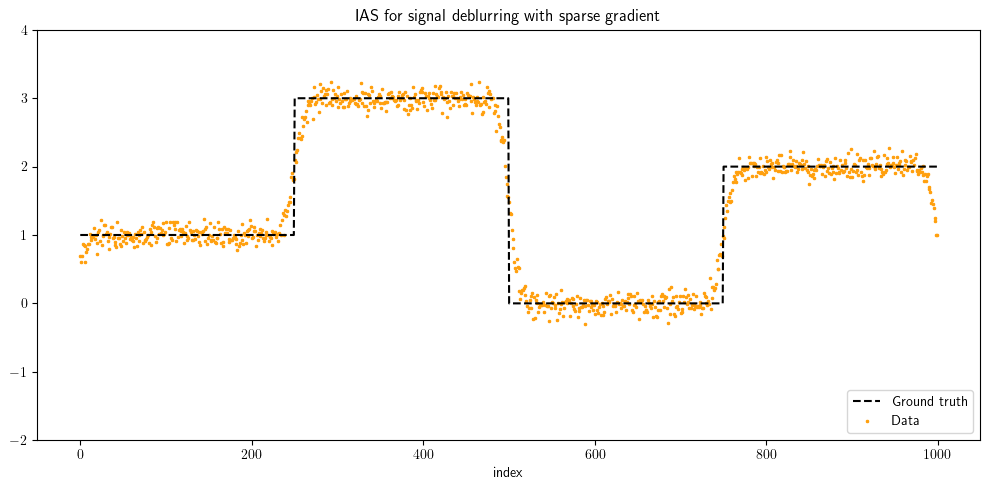

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# # Sample data
# x = np.arange(0, len(data["x"]))
# y1 = data["x"]
plt.figure(figsize=(10,5))
plt.plot(grid, ground_truth, label="Ground truth", color="black", ls="--")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_orange"], alpha=1.0, s=3.0)
plt.ylim(-2,4)
plt.legend(loc="lower right")
plt.title('IAS for signal deblurring with sparse gradient')
plt.xlabel("index")

plt.tight_layout()
plt.savefig("l1_deblur_data.png", dpi=250, bbox_inches="tight")
plt.savefig("l1_deblur_data.eps", bbox_inches="tight")


plt.show()


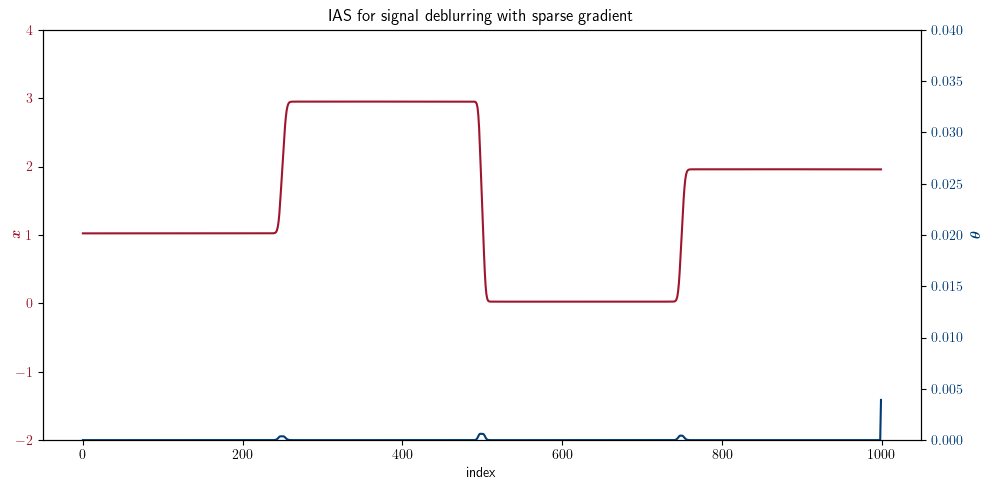

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.arange(0, len(data["x"]))
y1 = data["x"]
y2 = data["theta"]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot the first set of data
color = dcolors['bonfire_red']
ax1.set_xlabel('index')
ax1.set_ylabel('$\\bm x$', color=color, va="bottom", rotation=270)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-2,4)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
color = dcolors['river_navy']
ax2.set_ylabel('$\\boldsymbol{\\theta}$', color=color, rotation=270, va="bottom")  
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.04)

ax1.set_title('IAS for signal deblurring with sparse gradient')

fig.tight_layout()

fig.savefig("l1_deblur_result.png", dpi=250, bbox_inches="tight")
fig.savefig("l1_deblur_result.eps", bbox_inches="tight")




plt.show()


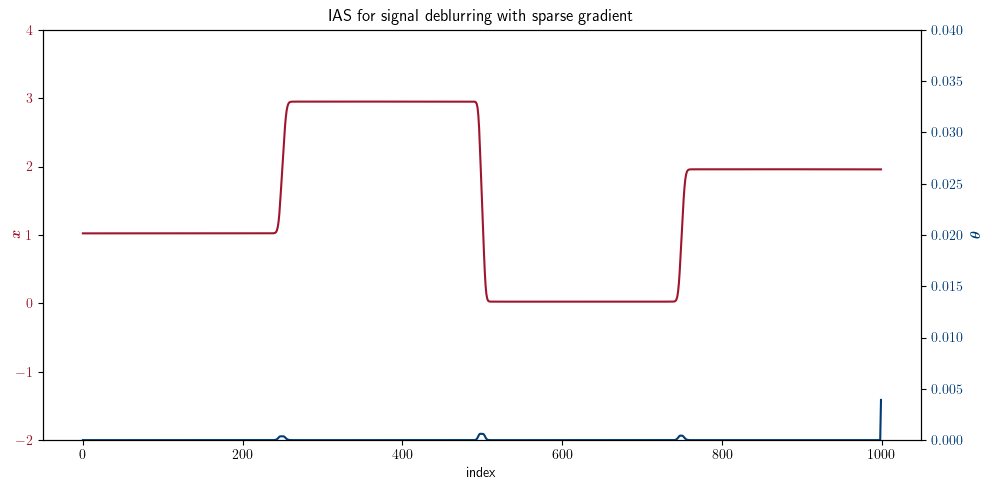

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.arange(0, len(data["x"]))
y1 = data["x"]
y2 = data["theta"]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot the first set of data
color = dcolors['bonfire_red']
ax1.set_xlabel('index')
ax1.set_ylabel('$\\bm x$', color=color, va="bottom", rotation=270)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-2,4)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
color = dcolors['river_navy']
ax2.set_ylabel('$\\boldsymbol{\\theta}$', color=color, rotation=270, va="bottom")  
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.04)

ax1.set_title('IAS for signal deblurring with sparse gradient')

fig.tight_layout()

#fig.savefig("l1_deblur_result.png", dpi=250, bbox_inches="tight")
#fig.savefig("l1_deblur_result.eps", bbox_inches="tight")




plt.show()


In [129]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.exp(x / 10)

# # Create figure and axis
# fig, ax1 = plt.subplots()

# # Plot the first set of data
# color = 'tab:red'
# ax1.set_xlabel('x (shared)')
# ax1.set_ylabel('sin(x)', color=color)
# ax1.plot(x, y1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # Create a second y-axis that shares the same x-axis
# ax2 = ax1.twinx()  
# color = 'tab:blue'
# ax2.set_ylabel('exp(x/10)', color=color)  
# ax2.plot(x, y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# # Optional: Add a title and adjust layout
# plt.title('Two plots with shared X-axis and separate Y-axes')
# fig.tight_layout()

# plt.show()


In [169]:
solver.pdata

{'W': None,
 'Rpinv_factory': <function __main__.<lambda>(theta)>,
 'Rinv': None,
 'FWpinv': None}

# Transformed sampling

In [18]:
tsampler = sampi.PriorconditionedIASGaussianSampler(F, R, noisy_signal, data["theta"], pdata=pdata, noise_var=data["noise_var"])

In [28]:
tsdata = tsampler.sample(n_samples=1000, priorconditioning=True, warmstarting=True, tol=1e-3)

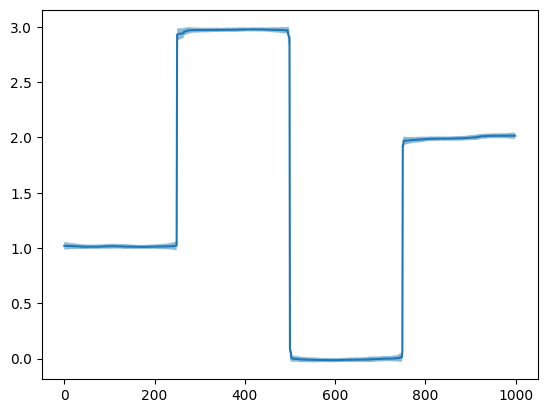

In [24]:
plt.plot(grid, tsdata["mean"])
sigmas = tsdata["stdev"]
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

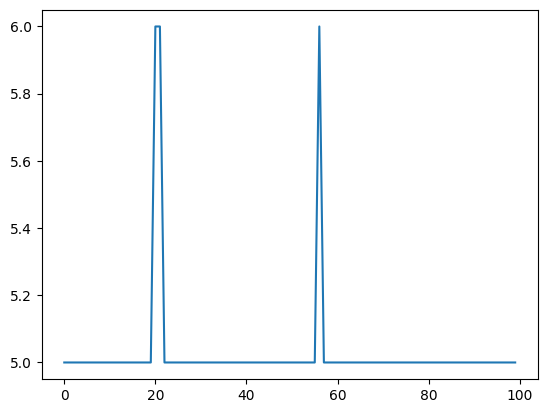

In [25]:
plt.plot(tsdata["n_cg_its_per_sample"])
plt.show()

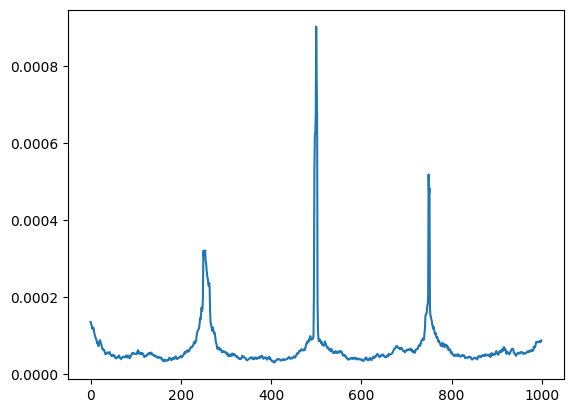

In [26]:
plt.plot(tsdata["var"])
plt.show()

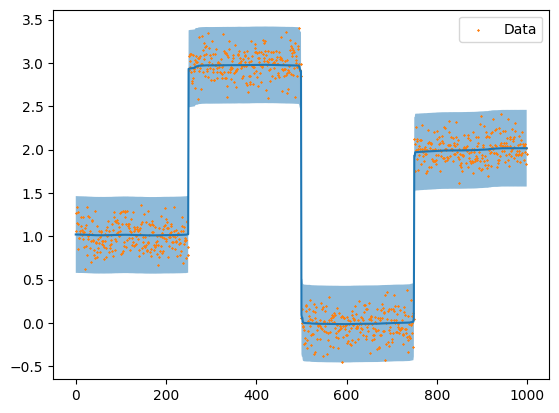

In [27]:
plt.plot(grid, tsdata["mean"])
marg_vars = tsdata["var"] + data["noise_var"]
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Sample the posterior (condition on fixed hyperparameters)

In [54]:
# Build sampler
map_noise_var = data["noise_var"]
map_theta = data["theta"]
Ftilde = (1.0/np.sqrt(map_noise_var))*F
ytilde = (1.0/np.sqrt(map_noise_var))*noisy_signal
Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(map_theta)) @ R

factors = [Ftilde, Rtilde]
shifts = [ytilde, None]

In [55]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [56]:
sdata = sampler.sample(n_samples=100, warmstarting=True, tol=1e-7)

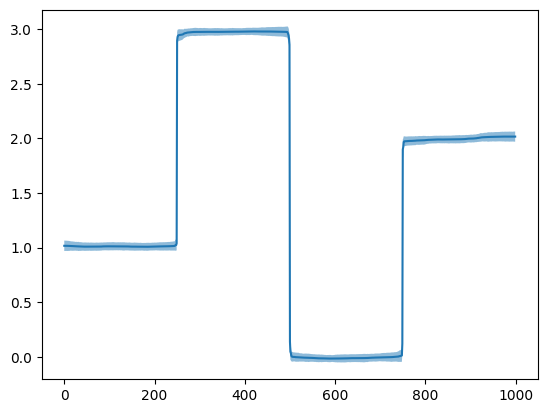

In [57]:
plt.plot(grid, sdata["mean"])
sigmas = sdata["stdev"]
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

In [58]:
sdata.keys()

dict_keys(['mean', 'stdev', 'var', 'n_cg_its_per_sample', 'tracker', 'obs_trackers'])

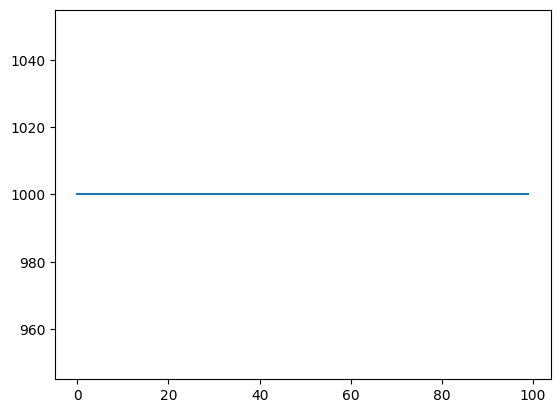

In [59]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

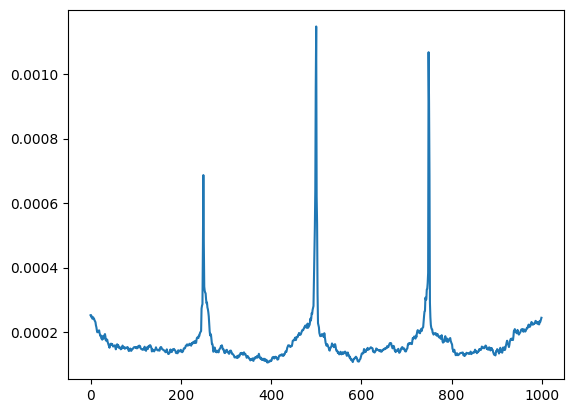

In [60]:
plt.plot(sdata["var"])
plt.show()

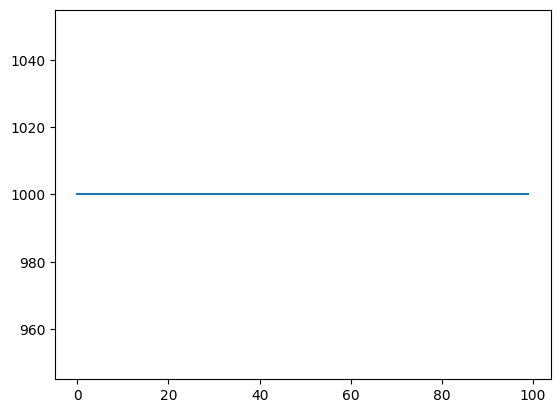

In [61]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

# Sample posterior predictive

In [23]:
post_pred_func = lambda z: z + np.sqrt(map_noise_var)*np.random.normal(size=z.shape)
#post_pred_func = lambda z: np.ones_like(z)

In [24]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [25]:
sdata = sampler.sample(n_samples=100, warmstarting=False, observables=[post_pred_func])

In [26]:
np.linalg.norm(sdata["tracker"].mean() - sdata["obs_trackers"][0].mean())

0.0

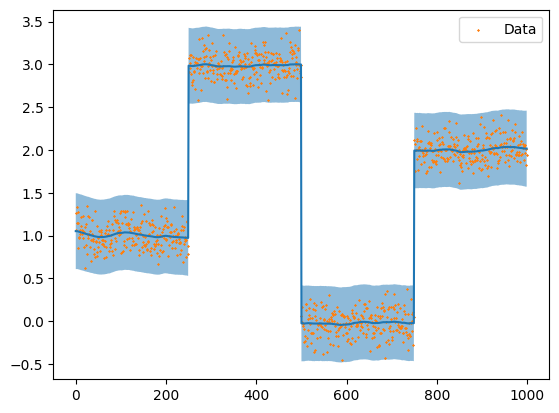

In [36]:
plt.plot(grid, sdata["mean"])
marg_vars = sdata["var"] + map_noise_var
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Compare to LASSO?

In [18]:
lasso_sampler = sampi.BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda=reg_lambda)

In [19]:
lasso_result = lasso_sampler.sample(n_samples=1000, n_burn=500)

AttributeError: 'IdentityOperator' object has no attribute 'A'